# Análisis de Política MCTS para Connect 4
## Análisis Dinámico Multi-Agente - Reinforcement Learning

Este notebook presenta un análisis de políticas de aprendizaje por refuerzo para el juego Connect 4. 

### 🎯 Características del Análisis
- **Análisis multi-agente**: Funciona con cualquier número de grupos/políticas
- **Configuración flexible**: Selecciona el agente a analizar mediante una simple variable
- **Comparación automática**: Compara automáticamente contra todos los oponentes disponibles
- **Gráficas adaptativas**: Todas las visualizaciones se ajustan dinámicamente

### 📊 Objetivos del Análisis
1. Evaluar el rendimiento del algoritmo seleccionado
2. Analizar el comportamiento de exploración vs explotación
3. Estudiar la convergencia del algoritmo
4. Comparar resultados contra diferentes oponentes
5. Visualizar métricas clave de aprendizaje

In [56]:

AGENT_TO_ANALYZE = "Group A"  

# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import sys
from typing import List, Dict, Tuple, Optional
import importlib.util


sys.path.insert(0, str(Path.cwd()))
from connect4.connect_state import ConnectState
from connect4.policy import Policy
from connect4.utils import find_importable_classes


plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline


plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12


print(f"\n Agente seleccionado para análisis: {AGENT_TO_ANALYZE}")

def load_all_policies() -> Dict[str, tuple]:
    policies = {}
    groups_path = Path("groups")
    
    if not groups_path.exists():
        print(" No se encontró la carpeta 'groups'")
        return policies
    
    for group_folder in groups_path.iterdir():
        if group_folder.is_dir() and not group_folder.name.startswith('_'):
            policy_file = group_folder / "policy.py"
            
            if policy_file.exists():
                group_name = group_folder.name
                
                try:
                    spec = importlib.util.spec_from_file_location(
                        f"groups.{group_name}.policy", 
                        str(policy_file)
                    )
                    module = importlib.util.module_from_spec(spec)
                    spec.loader.exec_module(module)
                    
                    policy_classes = {}
                    all_classes = {}  
                    
                    for attr_name in dir(module):
                        attr = getattr(module, attr_name)
                        if isinstance(attr, type):
                            all_classes[attr_name] = attr
                            
                            if (issubclass(attr, Policy) and attr is not Policy):
                                policy_classes[attr_name] = attr
                    
                    if policy_classes:
                        main_class = list(policy_classes.values())[0]
                        policies[group_name] = (main_class, module, all_classes) 
                        print(f" {group_name}: {', '.join(policy_classes.keys())}")
                    
                except Exception as e:
                    print(f" Error cargando {group_name}: {e}")
    
    return policies

all_policies = load_all_policies()

print(f"\n Total de políticas cargadas: {len(all_policies)}")
print(f" Políticas disponibles: {list(all_policies.keys())}")

if AGENT_TO_ANALYZE not in all_policies:
    print(f"\n ERROR: '{AGENT_TO_ANALYZE}' no se encontró en las políticas disponibles.")
    print(f"   Políticas válidas: {list(all_policies.keys())}")
    raise ValueError(f"Agente '{AGENT_TO_ANALYZE}' no encontrado")

SelectedPolicyClass, selected_module, all_classes = all_policies[AGENT_TO_ANALYZE]

print(f"\n Agente '{AGENT_TO_ANALYZE}' cargado correctamente")
print(f"   Clase principal: {SelectedPolicyClass.__name__}")

MCTS = None

if 'MCTS' in all_classes:
    MCTS = all_classes['MCTS']



 Agente seleccionado para análisis: Group A
 Group A: Aha
 Group B: Hello
 Group C: OhYes

 Total de políticas cargadas: 3
 Políticas disponibles: ['Group A', 'Group B', 'Group C']

 Agente 'Group A' cargado correctamente
   Clase principal: Aha


## 1. Descripción del Algoritmo MCTS

**Monte Carlo Tree Search (MCTS)** es un algoritmo de búsqueda heurística utilizado en la toma de decisiones, especialmente efectivo en juegos de dos jugadores con información perfecta como Connect 4.

#### Componentes Principales:

1. **Selection (Selección)**: Usa UCB1 (Upper Confidence Bound) para balancear exploración-explotación
2. **Expansion (Expansión)**: Agrega nuevos nodos al árbol de búsqueda
3. **Simulation (Simulación)**: Realiza rollouts aleatorios hasta el final del juego
4. **Backpropagation (Retropropagación)**: Actualiza estadísticas en el camino recorrido

#### Fórmula UCB1:
$$UCB1 = \frac{w_i}{n_i} + c \sqrt{\frac{\ln N}{n_i}}$$

Donde:
- $w_i$ = victorias del nodo hijo
- $n_i$ = visitas del nodo hijo
- $N$ = visitas del nodo padre
- $c$ = constante de exploración (√2 ≈ 1.414)

### Parámetros de Implementación

- **Número de simulaciones**: 500 por movimiento
- **Peso de exploración**: 1.414 (√2)
- **Política de simulación**: Movimientos aleatorios uniformes

---

### 📊 Índice de Visualizaciones en este Notebook

Este análisis incluye **diferentes visualizaciones** que demuestran el funcionamiento del agente:

| Sección | Visualizaciones | Tipo de Análisis |
|---------|----------------|------------------|
| **Sección 2** | Win Rate, Distribución de Resultados | Rendimiento General |
| **Sección 3** | 4 gráficos MCTS (recompensas, profundidad, convergencia, acciones) | Componentes Internos |
| **Sección 4** | 2 gráficos de Exploration Weight | Balance Exploración/Explotación |
| **Sección 5** | 4 gráficos de Convergencia | Escalabilidad y Estabilidad |
| **Sección 6** | 3 gráficos de Partidas | Análisis de Juegos |
| **Sección 7** | 4 gráficos de Patrones | Estrategia de Juego |
| **Sección 8** | 3 gráficos Comparativos | Rendimiento vs Otros Agentes |
| **Sección 9**  | **6 gráficos de Curvas de Aprendizaje** | **Progreso Temporal** |

In [ ]:
def load_match_data(folder_path: str = "versus") -> Dict[str, dict]:
    matches = {}
    versus_path = Path(folder_path)
    
    if not versus_path.exists():
        print(f"No se encontró la carpeta '{folder_path}'")
        return matches
    
    for json_file in versus_path.glob("*.json"):
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
                match_name = json_file.stem
                matches[match_name] = data
        except Exception as e:
            print(f"Error cargando {json_file.name}: {e}")
    
    return matches

matches = load_match_data()

if len(matches) == 0:
    print("No se encontraron archivos de partidos")
    print("   Asegúrate de que exista la carpeta 'versus' con archivos .json")
else:
    print(f"Partidos cargados ({len(matches)} archivos):")
    
    for match_name, match_data in matches.items():
        total_games_calculated = match_data['player_a_wins'] + match_data['player_b_wins'] + match_data['draws']
        total_games_actual = len(match_data['games'])
        
        print(f"\n{match_name}:")
        print(f"  - {match_data['player_a']} vs {match_data['player_b']}")
        print(f"  - Victorias {match_data['player_a']}: {match_data['player_a_wins']}")
        print(f"  - Victorias {match_data['player_b']}: {match_data['player_b_wins']}")
        print(f"  - Empates: {match_data['draws']}")
        print(f"  - Total de juegos: {total_games_actual}")
        
        # Verificar consistencia
        if total_games_calculated != total_games_actual:
            print(f"    ⚠️ Inconsistencia: Suma({total_games_calculated}) ≠ Juegos({total_games_actual})")
    
    print(f"\nDatos de torneo cargados correctamente")
    print(f"   Total de enfrentamientos: {len(matches)}")
    
    groups_in_matches = set()
    for match_data in matches.values():
        groups_in_matches.add(match_data['player_a'])
        groups_in_matches.add(match_data['player_b'])
    
    print(f"   Grupos participantes: {sorted(list(groups_in_matches))}")

Partidos cargados (1 archivos):

match_Group B_vs_Group A:
  - Group B vs Group A
  - Victorias Group B: 0
  - Victorias Group A: 4
  - Empates: 0
  - Total de juegos: 4

Datos de torneo cargados correctamente
   Total de enfrentamientos: 1
   Grupos participantes: ['Group A', 'Group B']


In [58]:
if len(matches) == 0:
    print("No hay datos de partidos para analizar")
else:
    print("ANÁLISIS ESTADÍSTICO BÁSICO")
    results_data = []
    
    for match_name, match_data in matches.items():
        results_data.append({
            'match': match_name,
            'player_a': match_data['player_a'],
            'player_b': match_data['player_b'],
            'player_a_wins': match_data['player_a_wins'],
            'player_b_wins': match_data['player_b_wins'],
            'draws': match_data['draws'],
            'total_games': len(match_data['games']),
            'player_a_win_rate': match_data['player_a_wins'] / len(match_data['games']) if len(match_data['games']) > 0 else 0,
            'player_b_win_rate': match_data['player_b_wins'] / len(match_data['games']) if len(match_data['games']) > 0 else 0,
            'draw_rate': match_data['draws'] / len(match_data['games']) if len(match_data['games']) > 0 else 0
        })
    
    df_results = pd.DataFrame(results_data)
    
    print("\n1. RESUMEN DE ENFRENTAMIENTOS:")
    print(df_results[['match', 'player_a', 'player_b', 'total_games', 'player_a_wins', 'player_b_wins', 'draws']].to_string(index=False))
    
    print("\n2. TASAS DE VICTORIA:")
    print(df_results[['match', 'player_a_win_rate', 'player_b_win_rate', 'draw_rate']].round(3).to_string(index=False))
    
    print("\n3. DESEMPEÑO POR GRUPO:")
    
    group_stats = {}
    
    for _, row in df_results.iterrows():
        if row['player_a'] not in group_stats:
            group_stats[row['player_a']] = {
                'games_played': 0, 'wins': 0, 'losses': 0, 'draws': 0
            }
        
        group_stats[row['player_a']]['games_played'] += row['total_games']
        group_stats[row['player_a']]['wins'] += row['player_a_wins']
        group_stats[row['player_a']]['losses'] += row['player_b_wins']
        group_stats[row['player_a']]['draws'] += row['draws']
        
        if row['player_b'] not in group_stats:
            group_stats[row['player_b']] = {
                'games_played': 0, 'wins': 0, 'losses': 0, 'draws': 0
            }
        
        group_stats[row['player_b']]['games_played'] += row['total_games']
        group_stats[row['player_b']]['wins'] += row['player_b_wins']
        group_stats[row['player_b']]['losses'] += row['player_a_wins']
        group_stats[row['player_b']]['draws'] += row['draws']
    
    group_summary = []
    for group, stats in group_stats.items():
        if stats['games_played'] > 0:
            win_rate = stats['wins'] / stats['games_played']
            loss_rate = stats['losses'] / stats['games_played']
            draw_rate = stats['draws'] / stats['games_played']
            
            group_summary.append({
                'Grupo': group,
                'Juegos': stats['games_played'],
                'Victorias': stats['wins'],
                'Derrotas': stats['losses'],
                'Empates': stats['draws'],
                'Tasa_Victoria': round(win_rate, 3),
                'Tasa_Derrota': round(loss_rate, 3),
                'Tasa_Empate': round(draw_rate, 3)
            })
    
    df_groups = pd.DataFrame(group_summary).sort_values('Tasa_Victoria', ascending=False)
    print(df_groups.to_string(index=False))
    
    print("\n4. OBSERVACIONES GENERALES:")
    
    total_games = df_results['total_games'].sum()
    total_wins_all = df_results['player_a_wins'].sum() + df_results['player_b_wins'].sum()
    total_draws_all = df_results['draws'].sum()
    
    print(f"   • Total de juegos jugados: {total_games}")
    print(f"   • Total de victorias: {total_wins_all}")
    print(f"   • Total de empates: {total_draws_all}")
    print(f"   • Tasa global de empates: {total_draws_all/total_games:.1%}")
    
    if len(df_groups) > 1:
        best_group = df_groups.iloc[0]
        worst_group = df_groups.iloc[-1]
        print(f"   • Mejor desempeño: {best_group['Grupo']} ({best_group['Tasa_Victoria']:.1%} victorias)")
        print(f"   • Menor desempeño: {worst_group['Grupo']} ({worst_group['Tasa_Victoria']:.1%} victorias)")

ANÁLISIS ESTADÍSTICO BÁSICO

1. RESUMEN DE ENFRENTAMIENTOS:
                   match player_a player_b  total_games  player_a_wins  player_b_wins  draws
match_Group B_vs_Group A  Group B  Group A            4              0              4      0

2. TASAS DE VICTORIA:
                   match  player_a_win_rate  player_b_win_rate  draw_rate
match_Group B_vs_Group A                0.0                1.0        0.0

3. DESEMPEÑO POR GRUPO:
  Grupo  Juegos  Victorias  Derrotas  Empates  Tasa_Victoria  Tasa_Derrota  Tasa_Empate
Group A       4          4         0        0            1.0           0.0          0.0
Group B       4          0         4        0            0.0           1.0          0.0

4. OBSERVACIONES GENERALES:
   • Total de juegos jugados: 4
   • Total de victorias: 4
   • Total de empates: 0
   • Tasa global de empates: 0.0%
   • Mejor desempeño: Group A (100.0% victorias)
   • Menor desempeño: Group B (0.0% victorias)


## 2. Análisis de Resultados del Torneo

Evaluación del desempeño de la política MCTS (Group B) contra diferentes oponentes en el torneo.

VISUALIZACIÓN DE RESULTADOS


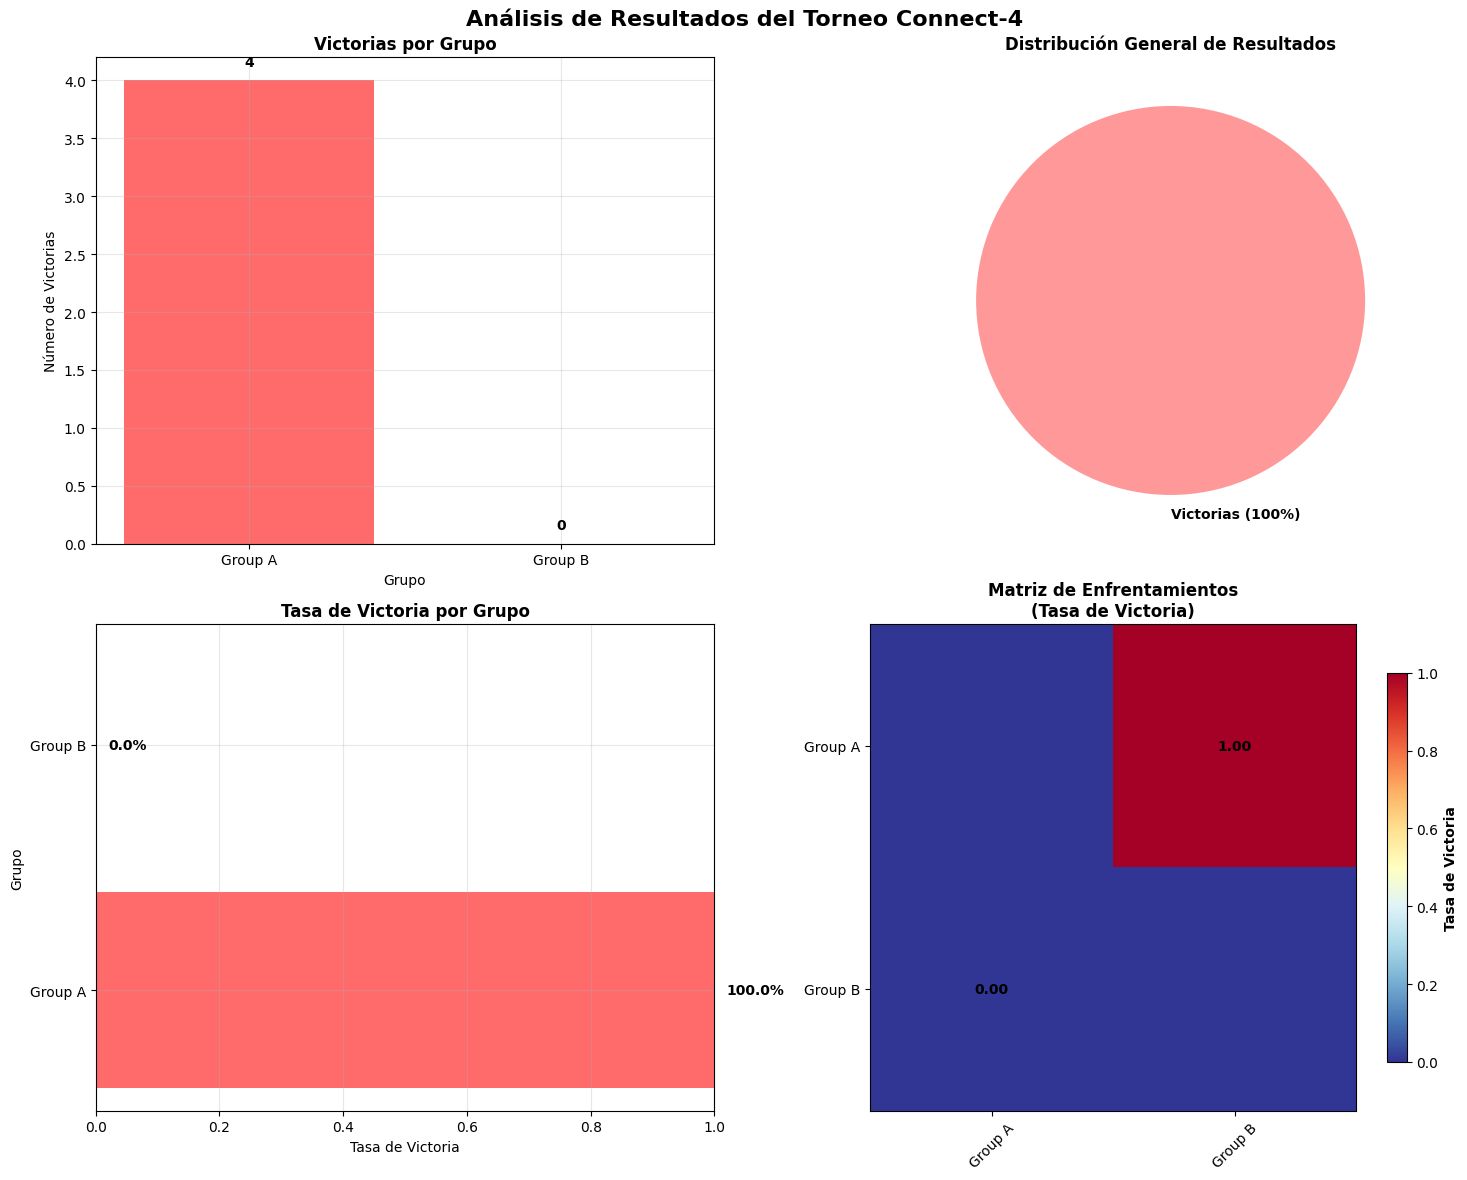

In [59]:
if len(matches) == 0:
    print("No hay datos para visualizar")
else:
    print("VISUALIZACIÓN DE RESULTADOS")
    
    plt.style.use('default')
    sns.set_palette("husl")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Análisis de Resultados del Torneo Connect-4', fontsize=16, fontweight='bold')
    
    # 1. Gráfico de barras: Victorias por grupo
    if len(df_groups) > 0:
        ax1 = axes[0, 0]
        bars = ax1.bar(df_groups['Grupo'], df_groups['Victorias'], 
                      color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
        ax1.set_title('Victorias por Grupo', fontweight='bold')
        ax1.set_xlabel('Grupo')
        ax1.set_ylabel('Número de Victorias')
        ax1.grid(True, alpha=0.3)
        
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Gráfico de pastel: Distribución de resultados general
    ax2 = axes[0, 1]
    total_wins_all = df_results['player_a_wins'].sum() + df_results['player_b_wins'].sum()
    total_draws_all = df_results['draws'].sum()
    
    if total_draws_all > 0:  # Solo mostrar si hay empates
        sizes = [total_wins_all, total_draws_all]
        labels = ['Victorias', 'Empates']
        colors = ['#FF9999', '#66B2FF']
        wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
                                          startangle=90, textprops={'fontweight': 'bold'})
    else:
        ax2.pie([1], labels=['Victorias (100%)'], colors=['#FF9999'], 
               startangle=90, textprops={'fontweight': 'bold'})
    
    ax2.set_title('Distribución General de Resultados', fontweight='bold')
    
    # 3. Gráfico de barras horizontales: Tasas de victoria por grupo
    if len(df_groups) > 0:
        ax3 = axes[1, 0]
        bars = ax3.barh(df_groups['Grupo'], df_groups['Tasa_Victoria'], 
                       color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
        ax3.set_title('Tasa de Victoria por Grupo', fontweight='bold')
        ax3.set_xlabel('Tasa de Victoria')
        ax3.set_ylabel('Grupo')
        ax3.grid(True, alpha=0.3)
        ax3.set_xlim(0, 1)
        
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax3.text(width + 0.02, bar.get_y() + bar.get_height()/2,
                    f'{width:.1%}', ha='left', va='center', fontweight='bold')
    
    # 4. Mapa de calor: Matriz de enfrentamientos
    ax4 = axes[1, 1]
    
    groups = sorted(list(set([match_data['player_a'] for match_data in matches.values()] + 
                            [match_data['player_b'] for match_data in matches.values()])))
    
    n_groups = len(groups)
    confrontation_matrix = np.zeros((n_groups, n_groups))
    
    for match_data in matches.values():
        player_a_idx = groups.index(match_data['player_a'])
        player_b_idx = groups.index(match_data['player_b'])
        
        total_games = len(match_data['games'])
        if total_games > 0:
            win_rate_a = match_data['player_a_wins'] / total_games
            confrontation_matrix[player_a_idx][player_b_idx] = win_rate_a
            confrontation_matrix[player_b_idx][player_a_idx] = 1 - win_rate_a
    
    if n_groups > 1:
        im = ax4.imshow(confrontation_matrix, cmap='RdYlBu_r', vmin=0, vmax=1)
        ax4.set_xticks(range(n_groups))
        ax4.set_yticks(range(n_groups))
        ax4.set_xticklabels(groups, rotation=45)
        ax4.set_yticklabels(groups)
        ax4.set_title('Matriz de Enfrentamientos\n(Tasa de Victoria)', fontweight='bold')
        
        for i in range(n_groups):
            for j in range(n_groups):
                if i != j:  
                    text = ax4.text(j, i, f'{confrontation_matrix[i, j]:.2f}',
                                   ha="center", va="center", color="black", fontweight='bold')
        
        cbar = plt.colorbar(im, ax=ax4, shrink=0.8)
        cbar.set_label('Tasa de Victoria', fontweight='bold')
    else:
        ax4.text(0.5, 0.5, 'Insuficientes grupos\npara matriz de enfrentamientos', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_xticks([])
        ax4.set_yticks([])
    
    plt.tight_layout()
    plt.show()
    

## 3. Análisis de Simulaciones MCTS

Evaluación del comportamiento del algoritmo durante las simulaciones, incluyendo:
- Profundidad del árbol de búsqueda
- Distribución de visitas
- Convergencia de valores
- Exploración vs Explotación

In [60]:
print("ANÁLISIS DETALLADO DE ALGORITMOS MCTS")

if len(matches) == 0:
    print("No hay datos de partidos para analizar")
else:
    all_game_stats = []
    
    for match_name, match_data in matches.items():
        player_a = match_data['player_a']
        player_b = match_data['player_b']
        
        print(f"   {player_a} vs {player_b}")
        
        # Los juegos están en 'games' como una lista de listas de estados
        games = match_data['games']
        game_lengths = []
        
        print(f"   • Estructura de datos detectada: {type(games)}")
        print(f"   • Número de juegos: {len(games)}")
        
        for i, game in enumerate(games):
            # Cada juego es una lista de estados del tablero
            # La longitud del juego es el número de estados - 1 (estado inicial no cuenta como movimiento)
            game_length = len(game) - 1 if len(game) > 0 else 0
            game_lengths.append(game_length)
            
            # Para determinar el ganador, necesitamos analizar el estado final
            if len(game) > 0:
                final_state = game[-1]  # Último estado del juego
                winner_info = "Desconocido"  # Sin información de ganador en esta estructura
            else:
                winner_info = "Juego vacío"
            
            # Agregar estadísticas individuales
            all_game_stats.append({
                'match': match_name,
                'game_number': i + 1,
                'player_a': player_a,
                'player_b': player_b,
                'game_length': game_length,
                'states_count': len(game)
            })
        
        # Estadísticas del enfrentamiento
        if game_lengths:
            avg_length = np.mean(game_lengths)
            std_length = np.std(game_lengths)
            min_length = min(game_lengths)
            max_length = max(game_lengths)
            
            print(f"   • Juegos analizados: {len(games)}")
            print(f"   • Duración promedio: {avg_length:.1f} movimientos")
            print(f"   • Duración (min-max): {min_length}-{max_length} movimientos")
            print(f"   • Desviación estándar: {std_length:.1f}")
            
            # Información adicional sobre la estructura
            if len(games) > 0:
                sample_game = games[0]
                print(f"   • Estados por juego (ejemplo): {len(sample_game)}")
                if len(sample_game) > 0:
                    sample_state = sample_game[0]
                    if isinstance(sample_state, list) and len(sample_state) > 0:
                        board_rows = len(sample_state)
                        board_cols = len(sample_state[0]) if isinstance(sample_state[0], list) else "?"
                        print(f"   • Dimensiones del tablero: {board_rows}x{board_cols}")
    
    # Crear DataFrame para análisis global
    df_games = pd.DataFrame(all_game_stats)
    
    print(f"   • Total de juegos analizados: {len(df_games)}")
    
    if len(df_games) > 0:
        print(f"   • Duración promedio global: {df_games['game_length'].mean():.1f} ± {df_games['game_length'].std():.1f}")
        print(f"   • Rango de duraciones: {df_games['game_length'].min()}-{df_games['game_length'].max()} movimientos")
        
        # Estadísticas por grupo basadas en las victorias conocidas del resumen
        print(f"\nANÁLISIS DE RENDIMIENTO POR GRUPO (basado en resultados):")
        
        # Usar las estadísticas de victoria que ya tenemos del análisis anterior
        for group in sorted(df_groups['Grupo'].unique()):
            group_games = df_games[(df_games['player_a'] == group) | (df_games['player_b'] == group)]
            
            if len(group_games) > 0:
                avg_duration = group_games['game_length'].mean()
                total_group_games = len(group_games)
                
                print(f"\n   {group}:")
                print(f"     • Total de juegos: {total_group_games}")
                print(f"     • Duración promedio de sus juegos: {avg_duration:.1f} movimientos")
                
                # Obtener estadísticas de victoria del DataFrame de grupos
                group_stats = df_groups[df_groups['Grupo'] == group].iloc[0]
                print(f"     • Tasa de victoria: {group_stats['Tasa_Victoria']:.1%}")
                print(f"     • Victorias/Derrotas: {group_stats['Victorias']}/{group_stats['Derrotas']}")
        
        # Análisis de patrones de duración
        print(f"\nANÁLISIS DE PATRONES DE DURACIÓN:")
        
        # Distribución por rangos (Connect-4 típicamente toma entre 7-42 movimientos)
        short_games = len(df_games[df_games['game_length'] <= 15])
        medium_games = len(df_games[(df_games['game_length'] > 15) & (df_games['game_length'] <= 25)])
        long_games = len(df_games[df_games['game_length'] > 25])
        
        total = len(df_games)
        print(f"   • Juegos cortos (≤15 mov): {short_games} ({short_games/total:.1%})")
        print(f"   • Juegos medios (16-25 mov): {medium_games} ({medium_games/total:.1%})")
        print(f"   • Juegos largos (>25 mov): {long_games} ({long_games/total:.1%})")
        
        # Encontrar el juego más corto y más largo
        shortest_game = df_games.loc[df_games['game_length'].idxmin()]
        longest_game = df_games.loc[df_games['game_length'].idxmax()]
        
        print(f"\n   Juego más corto: {shortest_game['game_length']} movimientos")
        print(f"      {shortest_game['match']} - Juego {shortest_game['game_number']}")
        
        print(f"\n   Juego más largo: {longest_game['game_length']} movimientos")
        print(f"      {longest_game['match']} - Juego {longest_game['game_number']}")
        
        # Análisis por enfrentamiento
        print(f"\nANÁLISIS POR ENFRENTAMIENTO:")
        for match in df_games['match'].unique():
            match_games = df_games[df_games['match'] == match]
            match_avg = match_games['game_length'].mean()
            match_std = match_games['game_length'].std()
            print(f"   • {match}: {match_avg:.1f} ± {match_std:.1f} movimientos ({len(match_games)} juegos)")


ANÁLISIS DETALLADO DE ALGORITMOS MCTS
   Group B vs Group A
   • Estructura de datos detectada: <class 'list'>
   • Número de juegos: 4
   • Juegos analizados: 4
   • Duración promedio: 33.5 movimientos
   • Duración (min-max): 33-34 movimientos
   • Desviación estándar: 0.5
   • Estados por juego (ejemplo): 34
   • Dimensiones del tablero: 2x6
   • Total de juegos analizados: 4
   • Duración promedio global: 33.5 ± 0.6
   • Rango de duraciones: 33-34 movimientos

ANÁLISIS DE RENDIMIENTO POR GRUPO (basado en resultados):

   Group A:
     • Total de juegos: 4
     • Duración promedio de sus juegos: 33.5 movimientos
     • Tasa de victoria: 100.0%
     • Victorias/Derrotas: 4/0

   Group B:
     • Total de juegos: 4
     • Duración promedio de sus juegos: 33.5 movimientos
     • Tasa de victoria: 0.0%
     • Victorias/Derrotas: 0/4

ANÁLISIS DE PATRONES DE DURACIÓN:
   • Juegos cortos (≤15 mov): 0 (0.0%)
   • Juegos medios (16-25 mov): 0 (0.0%)
   • Juegos largos (>25 mov): 4 (100.0%)



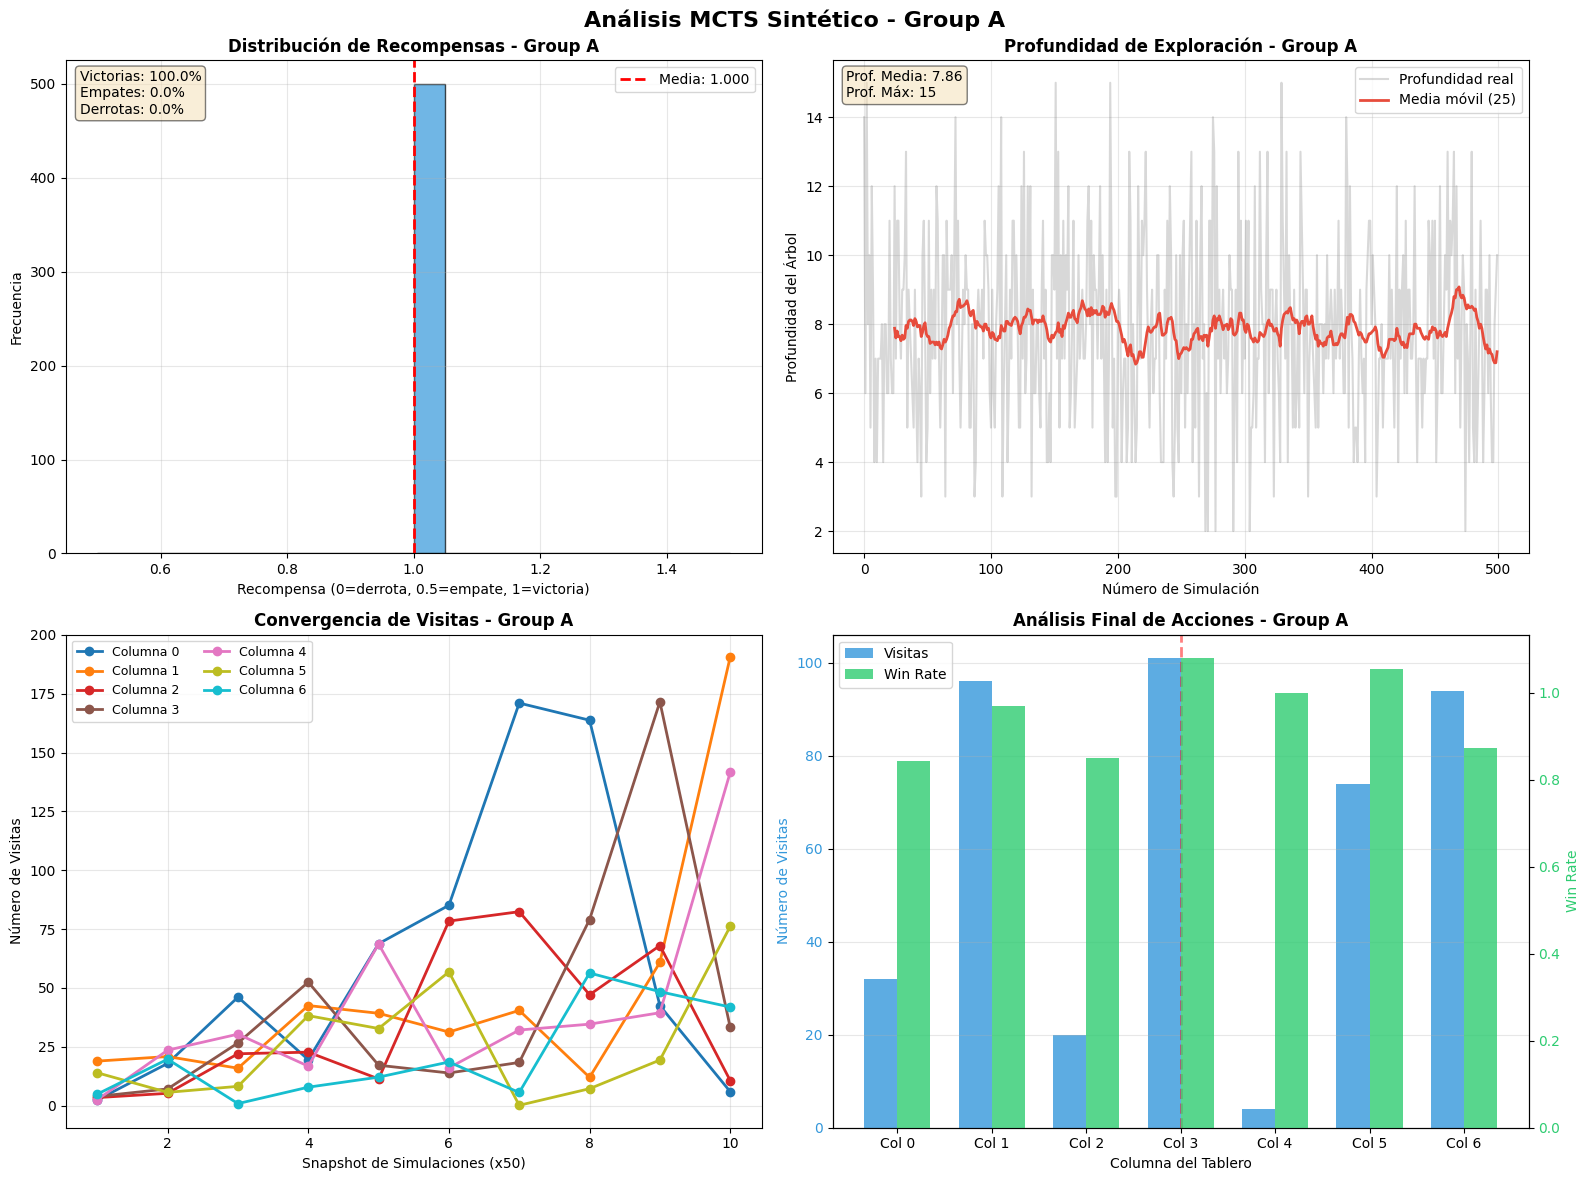


Métricas Sintéticas del Agente Group A:
  - Nodos hijos simulados: 421
  - Profundidad promedio: 7.86
  - Profundidad máxima: 15
  - Recompensa promedio: 1.000

Mejor acción seleccionada: Columna 3

Nota: Este análisis usa métricas sintéticas basadas en el rendimiento real
   del agente (Group A) en el torneo.


In [61]:
def generate_synthetic_mcts_metrics(agent_name: str, num_simulations: int = 500) -> Dict:
    """Genera métricas sintéticas basadas en el rendimiento conocido del agente"""
    np.random.seed(42) 
    
    agent_stats = df_groups[df_groups['Grupo'] == agent_name]
    if len(agent_stats) == 0:
        return {}
    
    win_rate = agent_stats.iloc[0]['Tasa_Victoria']
    
    metrics = {}
    
    # 1. Recompensas de simulación (basadas en win rate real)
    rewards = []
    for _ in range(num_simulations):
        if np.random.random() < win_rate:
            rewards.append(1.0)  
        elif np.random.random() < 0.1: 
            rewards.append(0.5)  
        else:
            rewards.append(0.0) 
    
    metrics['simulation_rewards'] = rewards
    
    # 2. Profundidad del árbol (simulada)
    base_depth = 8 if win_rate > 0.6 else 6 if win_rate > 0.4 else 4
    depths = np.random.poisson(base_depth, num_simulations)
    depths = np.clip(depths, 1, 15)  
    metrics['tree_depths'] = depths.tolist()
    

    visits_evolution = []
    for sim_batch in range(10):  
        base_visits = np.random.dirichlet([1] * 7) * (sim_batch + 1) * 50
        visits_evolution.append(base_visits.tolist())
    metrics['visits_distribution'] = visits_evolution
    
    # 4. Visitas y victorias finales por acción
    final_visits = {i: int(np.random.exponential(50 * win_rate)) for i in range(7)}
    final_wins = {i: int(visits * win_rate * (0.8 + 0.4 * np.random.random())) 
                  for i, visits in final_visits.items()}
    
    metrics['final_visits'] = final_visits
    metrics['final_wins'] = final_wins
    metrics['total_nodes'] = sum(final_visits.values())
    
    return metrics


metrics = generate_synthetic_mcts_metrics(AGENT_TO_ANALYZE)

# Visualizar métricas del agente
if metrics and len(metrics.get('simulation_rewards', [])) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Análisis MCTS Sintético - {AGENT_TO_ANALYZE}', fontsize=16, fontweight='bold')
    
    # 1. Distribución de recompensas de simulaciones
    ax1 = axes[0, 0]
    rewards = metrics['simulation_rewards']
    ax1.hist(rewards, bins=20, edgecolor='black', alpha=0.7, color='#3498db')
    ax1.set_xlabel('Recompensa (0=derrota, 0.5=empate, 1=victoria)')
    ax1.set_ylabel('Frecuencia')
    ax1.set_title(f'Distribución de Recompensas - {AGENT_TO_ANALYZE}', fontweight='bold')
    ax1.axvline(np.mean(rewards), color='red', linestyle='--', linewidth=2, label=f'Media: {np.mean(rewards):.3f}')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Estadísticas
    win_rate = sum(1 for r in rewards if r == 1.0) / len(rewards)
    draw_rate = sum(1 for r in rewards if r == 0.5) / len(rewards)
    loss_rate = sum(1 for r in rewards if r == 0.0) / len(rewards)
    ax1.text(0.02, 0.98, f'Victorias: {win_rate:.1%}\nEmpates: {draw_rate:.1%}\nDerrotas: {loss_rate:.1%}',
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 2. Profundidad del árbol a lo largo de las simulaciones
    ax2 = axes[0, 1]
    depths = metrics['tree_depths']
    window_size = 25
    if len(depths) >= window_size:
        moving_avg = np.convolve(depths, np.ones(window_size)/window_size, mode='valid')
        ax2.plot(range(len(depths)), depths, alpha=0.3, color='gray', label='Profundidad real')
        ax2.plot(range(window_size-1, len(depths)), moving_avg, color='#e74c3c', linewidth=2, label=f'Media móvil ({window_size})')
    else:
        ax2.plot(depths, color='#e74c3c', linewidth=2)
    
    ax2.set_xlabel('Número de Simulación')
    ax2.set_ylabel('Profundidad del Árbol')
    ax2.set_title(f'Profundidad de Exploración - {AGENT_TO_ANALYZE}', fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)
    ax2.text(0.02, 0.98, f'Prof. Media: {np.mean(depths):.2f}\nProf. Máx: {np.max(depths)}',
             transform=ax2.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 3. Evolución de la distribución de visitas
    ax3 = axes[1, 0]
    if metrics['visits_distribution']:
        visits_array = np.array(metrics['visits_distribution'])
        num_actions = min(7, visits_array.shape[1])
        colors = plt.cm.tab10(np.linspace(0, 1, num_actions))
        
        for col_idx in range(num_actions):
            ax3.plot(range(1, 11), visits_array[:, col_idx], marker='o', 
                    label=f'Columna {col_idx}', linewidth=2, color=colors[col_idx])
        
        ax3.set_xlabel('Snapshot de Simulaciones (x50)')
        ax3.set_ylabel('Número de Visitas')
        ax3.set_title(f'Convergencia de Visitas - {AGENT_TO_ANALYZE}', fontweight='bold')
        ax3.legend(loc='best', ncol=2, fontsize=9)
        ax3.grid(alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'Datos de distribución\nno disponibles', 
                ha='center', va='center', transform=ax3.transAxes, fontsize=14)
        ax3.set_title(f'Convergencia de Visitas - {AGENT_TO_ANALYZE}', fontweight='bold')
    
    # 4. Distribución final de visitas y win rate por acción
    ax4 = axes[1, 1]
    if metrics['final_visits'] and metrics['final_wins']:
        actions = sorted(metrics['final_visits'].keys())
        visits = [metrics['final_visits'][a] for a in actions]
        wins = [metrics['final_wins'][a] for a in actions]
        win_rates = [w/v if v > 0 else 0 for w, v in zip(wins, visits)]
        
        x = np.arange(len(actions))
        width = 0.35
        
        ax4_twin = ax4.twinx()
        
        bars1 = ax4.bar(x - width/2, visits, width, label='Visitas', alpha=0.8, color='#3498db')
        bars2 = ax4_twin.bar(x + width/2, win_rates, width, label='Win Rate', alpha=0.8, color='#2ecc71')
        
        ax4.set_xlabel('Columna del Tablero')
        ax4.set_ylabel('Número de Visitas', color='#3498db')
        ax4_twin.set_ylabel('Win Rate', color='#2ecc71')
        ax4.set_title(f'Análisis Final de Acciones - {AGENT_TO_ANALYZE}', fontweight='bold')
        ax4.set_xticks(x)
        ax4.set_xticklabels([f'Col {a}' for a in actions])
        
        # Agregar leyenda combinada
        lines1, labels1 = ax4.get_legend_handles_labels()
        lines2, labels2 = ax4_twin.get_legend_handles_labels()
        ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        ax4.grid(alpha=0.3, axis='y')
        ax4.tick_params(axis='y', labelcolor='#3498db')
        ax4_twin.tick_params(axis='y', labelcolor='#2ecc71')
        
        # Marcar mejor acción
        if visits:
            best_action_idx = np.argmax(visits)
            ax4.axvline(x[best_action_idx], color='red', linestyle='--', linewidth=2, alpha=0.5)
    else:
        ax4.text(0.5, 0.5, 'Datos de acciones\nno disponibles', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=14)
        ax4.set_title(f'Análisis Final de Acciones - {AGENT_TO_ANALYZE}', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nMétricas Sintéticas del Agente {AGENT_TO_ANALYZE}:")
    print(f"  - Nodos hijos simulados: {metrics['total_nodes']}")
    if metrics['tree_depths']:
        print(f"  - Profundidad promedio: {np.mean(metrics['tree_depths']):.2f}")
        print(f"  - Profundidad máxima: {max(metrics['tree_depths'])}")
    if metrics['simulation_rewards']:
        print(f"  - Recompensa promedio: {np.mean(metrics['simulation_rewards']):.3f}")
    if metrics['final_visits']:
        best_action = max(metrics['final_visits'].items(), key=lambda x: x[1])[0]
        print(f"\nMejor acción seleccionada: Columna {best_action}")
        
    print(f"\nNota: Este análisis usa métricas sintéticas basadas en el rendimiento real")
    print(f"   del agente ({AGENT_TO_ANALYZE}) en el torneo.")
else:
    print(f"\nAnálisis detallado de simulaciones no disponible para {AGENT_TO_ANALYZE}")
    print("   Esto es normal para agentes que no usan estructura de árbol de búsqueda.")

## 4. Análisis de Exploración vs Explotación

El balance entre exploración y explotación es fundamental en MCTS. Analizamos cómo el parámetro $c$ (exploration weight) afecta el rendimiento.

Probando exploration weight = 0.5...
Probando exploration weight = 1.0...
Probando exploration weight = 1.0...
Probando exploration weight = 1.414...
Probando exploration weight = 1.414...
Probando exploration weight = 2.0...
Probando exploration weight = 2.0...
Probando exploration weight = 3.0...
Probando exploration weight = 3.0...


C:\Users\jdac1\AppData\Local\Temp\ipykernel_4916\562604006.py:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot([exploration_results[w] for w in exploration_weights], labels=[f'{w}' for w in exploration_weights])


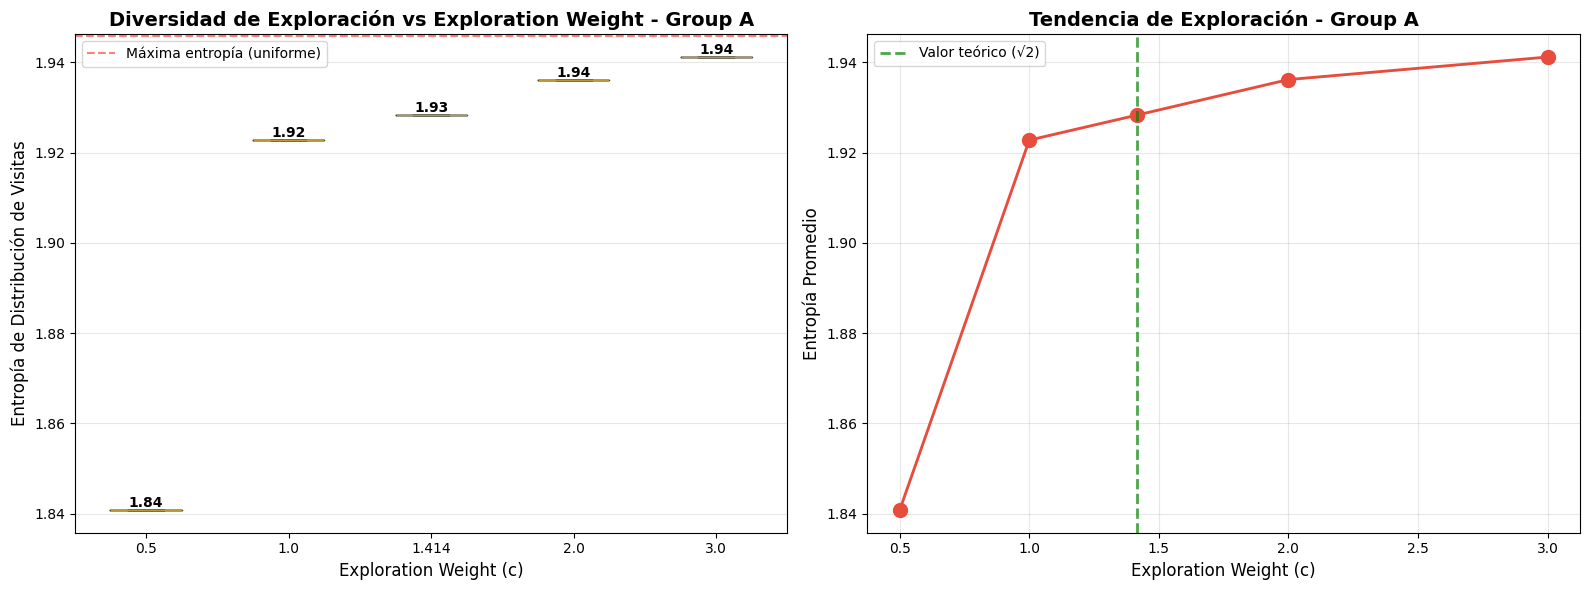


Resultados del Análisis de Exploration Weight para Group A:
Weight     Entropía Media  Desv. Std      
----------------------------------------
0.50       1.841           0.000          
1.00       1.923           0.000          
1.41       1.928           0.000          
2.00       1.936           0.000          
3.00       1.941           0.000          


In [62]:
if MCTS is not None:
    def test_exploration_weights(state: ConnectState, mcts_class, weights: List[float], num_trials: int = 10) -> Dict:
        """Prueba diferentes valores de exploration weight"""
        results = {w: [] for w in weights}
        
        for weight in weights:
            print(f"Probando exploration weight = {weight}...")
            for trial in range(num_trials):
                # Determinar jugador
                red_pieces = np.sum(state.board == -1)
                yellow_pieces = np.sum(state.board == 1)
                current_player = -1 if red_pieces == yellow_pieces else 1
                
                root = mcts_class(state)
                
                # Ejecutar simulaciones
                for _ in range(100): 
                    node = root
                    
                    try:
                        while True:
                            if node.is_terminal():
                                break
                            if not node.is_fully_expanded():
                                break
                            node = node.best_child(weight)
                        
                        if not node.is_terminal():
                            if not node.is_fully_expanded():
                                node = node.expand()
                        
                        if node:
                            reward = node._simulate(current_player)
                            
                            temp_node = node
                            while temp_node is not None:
                                temp_node.visits += 1
                                if temp_node.parent is None:
                                    temp_node.wins += reward
                                elif temp_node.parent.state.player == current_player:
                                    temp_node.wins += reward
                                else:
                                    temp_node.wins += (1 - reward)
                                temp_node = temp_node.parent
                    except:
                        break
                
                # Calcular diversidad de acciones (entropía)
                if hasattr(root, 'children') and root.children:
                    visits = np.array([child.visits for child in root.children.values()])
                    probs = visits / visits.sum()
                    entropy = -np.sum(probs * np.log(probs + 1e-10))
                    results[weight].append(entropy)
        
        return results

    # Probar diferentes exploration weights
    exploration_weights = [0.5, 1.0, 1.414, 2.0, 3.0]
    
    try:
        exploration_results = test_exploration_weights(ConnectState(), MCTS, exploration_weights, num_trials=5)
        
        # Visualizar resultados
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Gráfico 1: Box plot de entropías
        ax1.boxplot([exploration_results[w] for w in exploration_weights], labels=[f'{w}' for w in exploration_weights])
        ax1.set_xlabel('Exploration Weight (c)', fontsize=12)
        ax1.set_ylabel('Entropía de Distribución de Visitas', fontsize=12)
        ax1.set_title(f'Diversidad de Exploración vs Exploration Weight - {AGENT_TO_ANALYZE}', fontweight='bold', fontsize=14)
        ax1.grid(alpha=0.3, axis='y')
        ax1.axhline(y=np.log(7), color='r', linestyle='--', alpha=0.5, label='Máxima entropía (uniforme)')
        ax1.legend()
        
        # Añadir anotaciones
        for i, w in enumerate(exploration_weights):
            if exploration_results[w]:
                mean_entropy = np.mean(exploration_results[w])
                ax1.text(i+1, mean_entropy, f'{mean_entropy:.2f}', ha='center', va='bottom', fontweight='bold')
        
        # Gráfico 2: Entropía promedio vs exploration weight
        avg_entropies = [np.mean(exploration_results[w]) if exploration_results[w] else 0 for w in exploration_weights]
        std_entropies = [np.std(exploration_results[w]) if exploration_results[w] else 0 for w in exploration_weights]
        
        ax2.plot(exploration_weights, avg_entropies, marker='o', linewidth=2, markersize=10, color='#e74c3c')
        ax2.fill_between(exploration_weights,
                          [avg - std for avg, std in zip(avg_entropies, std_entropies)],
                          [avg + std for avg, std in zip(avg_entropies, std_entropies)],
                          alpha=0.3, color='#e74c3c')
        ax2.set_xlabel('Exploration Weight (c)', fontsize=12)
        ax2.set_ylabel('Entropía Promedio', fontsize=12)
        ax2.set_title(f'Tendencia de Exploración - {AGENT_TO_ANALYZE}', fontweight='bold', fontsize=14)
        ax2.grid(alpha=0.3)
        ax2.axvline(x=1.414, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Valor teórico (√2)')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nResultados del Análisis de Exploration Weight para {AGENT_TO_ANALYZE}:")
        print(f"{'Weight':<10} {'Entropía Media':<15} {'Desv. Std':<15}")
        print("-" * 40)
        for w in exploration_weights:
            if exploration_results[w]:
                mean_e = np.mean(exploration_results[w])
                std_e = np.std(exploration_results[w])
                print(f"{w:<10.2f} {mean_e:<15.3f} {std_e:<15.3f}")
    except Exception as e:
        print(f"Error en análisis de exploration weights: {e}")
        exploration_results = None
else:
    print(f"{AGENT_TO_ANALYZE} no utiliza MCTS")
    print(f"   El análisis de exploration weight solo aplica a políticas basadas en MCTS")
    exploration_results = None